In [1]:


import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("wifi.txt")



In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None, batch_train=True)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', batch_train=True)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500, batch_train=True)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997, batch_train=True)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

/home/aziza/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac,lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)


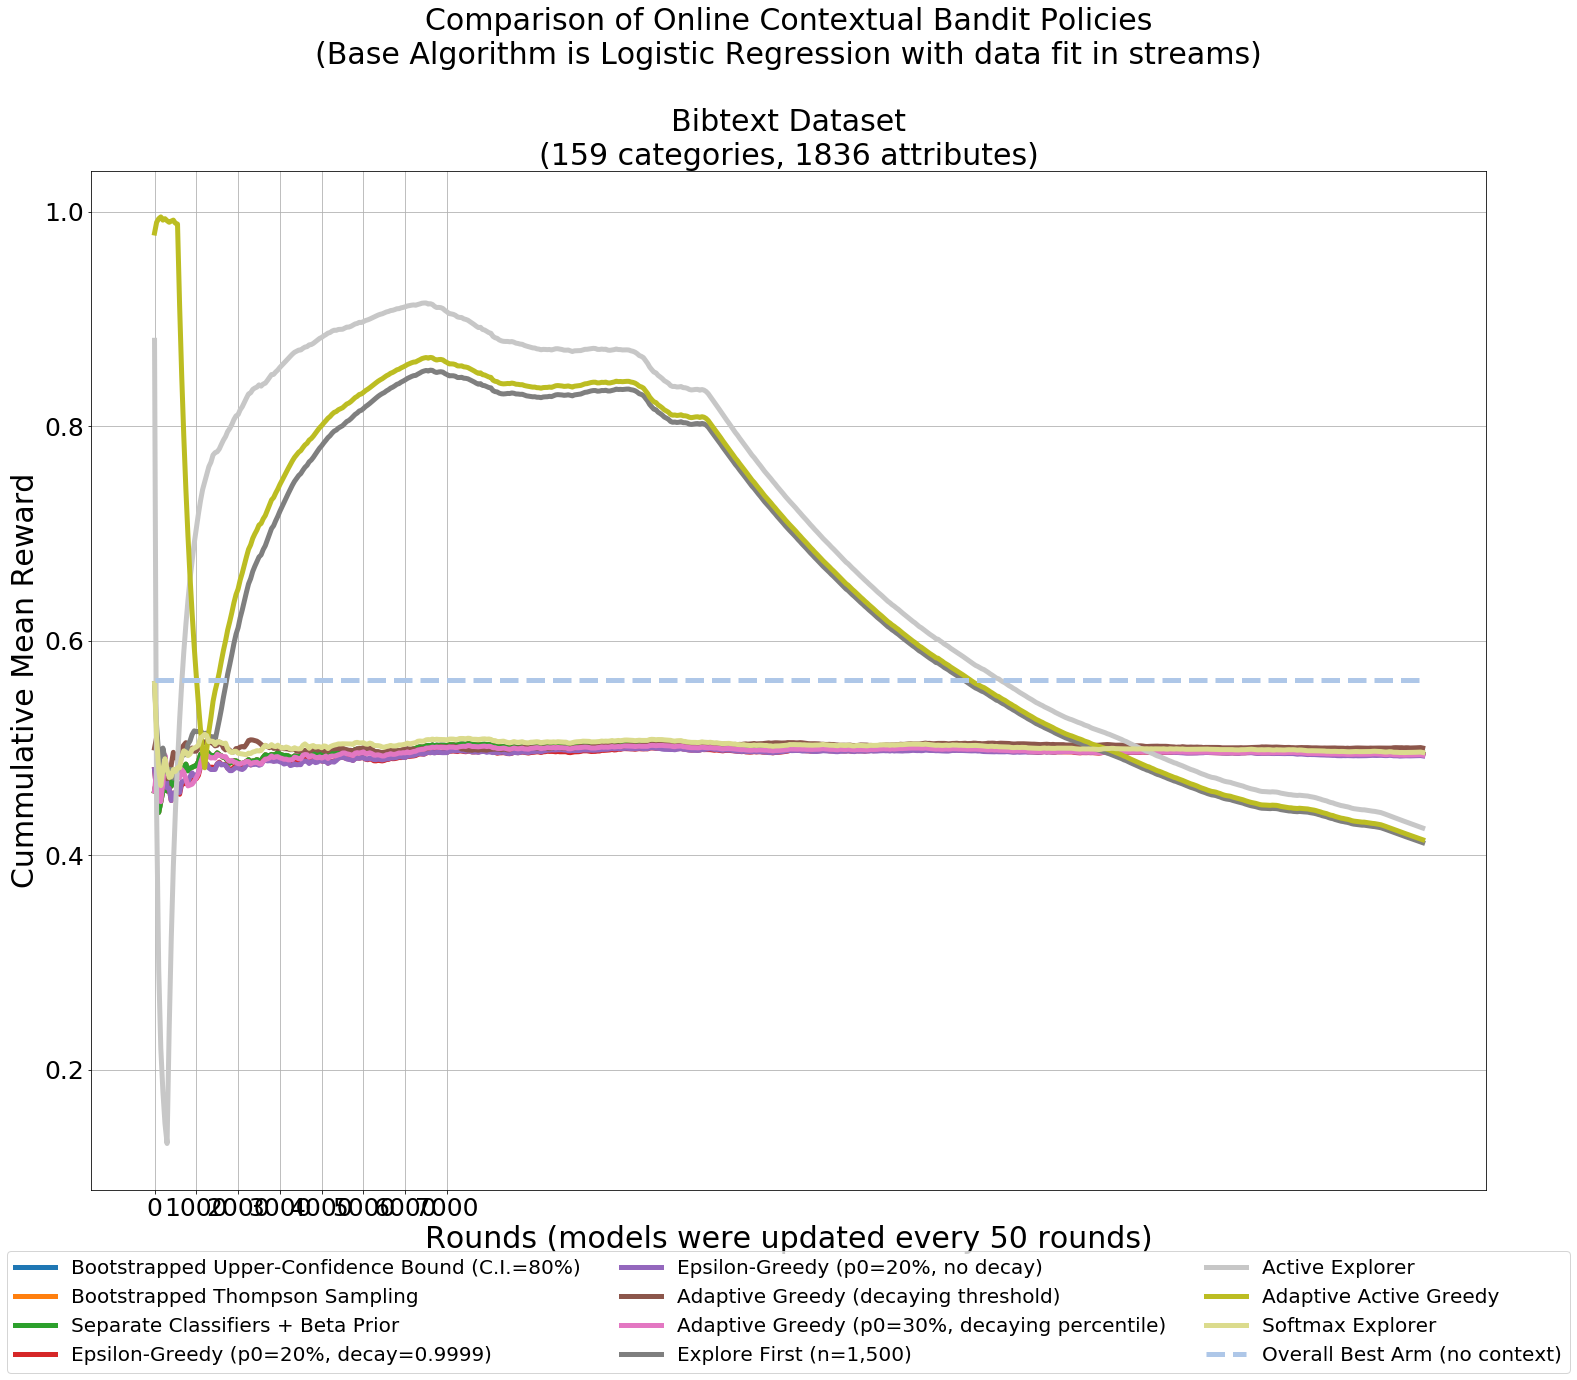

In [5]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()